In [ ]:
!pip install pyts
!pip install --upgrade pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys
from scipy import stats
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.backends.backend_pdf import PdfPages
import os
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def generate_random_vectors(n, r):
    random_vectors = np.random.normal(0, 1, size=(r, n))
    return random_vectors

def MINE(data,R,R_inv):

  prod = np.matmul(data,R)
  bitmap = np.where(prod < 0, 0, 1)
  recon = np.matmul(bitmap,R_inv)
  return recon

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Number of windows')

    if type == 'SC' :
     ax.set_ylabel('ACCURACY score')
     if method == 'RAW':
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'RMSE' :
     ax.set_ylabel('F1 score')
     if method == 'RAW':
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def plot_score_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

    #y_axis_limits = (-5, 5)  # axis limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)

        # Identify and count outliers based on the limits
        outliers = np.where((y < -5) | (y > 5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))
        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'ACCURACY scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}] ')
        ax.grid(True)

        # Set the y-axis limits
        #ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

def plot_F1_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

   # y_axis_limits = (-5, 5) # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)
        # Identify and count outliers based on the limits
        outliers = np.where((y < -5) | (y > 5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))

        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'F1 scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}]')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
       # ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig


# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
X= X[indices]
y= y[indices]
y[y == 0.5] = 0


# window size, etc.
window_sizes = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT','DCT','DWT','PAA','MINE']

#file for storing
folder_name = f"KNN PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))
pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
  for window_size in window_sizes:

     # lists to store metrics for each window
     f1_list = []
     accuracy_list = []
     num =int( window_size+window_size/4)
     # Iterate over the windows
     for i in range(0, len(X)-window_size*2+1, window_size):

          # Split the data into training and testing sets
          X_train = X[i:i+window_size]
          X_test = X[i+window_size:i+num]
          y_train = y[i:i+window_size]
          y_test = y[i+window_size:i+num]
          #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

          # Data scaling
          sc = MinMaxScaler()
          X_train_scaled = sc.fit_transform(X_train)
          X_test_scaled = sc.transform(X_test)

          #print(X_train_scaled[0], X_test_scaled[0], y_train_scaled[0], y_test_scaled[0])

          KNN_model = KNeighborsClassifier(n_neighbors=1)
          KNN_model.fit(X_train_scaled, y_train)

          # predictions
          y_pred_scaled  = KNN_model.predict(X_test_scaled)

          # performance
          accuracy = accuracy_score(y_test, y_pred_scaled)
          accuracy_list.append(accuracy)
          f1 = f1_score(y_test, y_pred_scaled)
          f1_list.append(f1)

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(accuracy_list,methd,window_size ,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     fig2 = plot_confidence_interval(f1_list,methd,window_size ,comprsn,'RMSE') #plot function call
     pdf.savefig(fig2)
     plt.close(fig2)

     # create a file name based on the method, subset index, stride, and compression
     avg_accuracy = np.mean(accuracy_list)
     file_name = f"Window size({window_size}) - accuracy-scores.txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average accuracy Score: {avg_accuracy}\n")
              content = str(accuracy_list)
              f.write(content)
              f.close()

     avg_f1 = np.mean(f1_list)
     file_name = f"Window size({window_size}) - f1 scores).txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average f1 Score: {avg_f1}\n")
              content = str(f1_list)
              f.write(content)
              f.close()


for window_size in window_sizes:

    #file for storing
    stride_folder_name = f"stride({window_size})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #vector and inverse vector arrays for our algorithm
        n = 64*int(window_size/compression)  # Dimension of each random vector
        r = 51  # Number of random vectors to generate/rows
        R = generate_random_vectors(n, r)
        R_inv= np.linalg.pinv(R)
       # print(R.shape,R_inv.shape)

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
            results1 = []
            results2 = []
            for method in methods:

                slices = window_size // compression

                # lists to store metrics for each window
                f1_list = []
                accuracy_list = []
                num =int( window_size+window_size/4)

                # Iterate over the windows
                for i in range(0, len(X)-window_size*2+1, window_size):

                   # Split the data into training and testing sets
                   X_train = X[i:i+window_size]
                   X_test = X[i+window_size:i+num]
                   y_train = y[i:i+window_size]
                   y_test = y[i+window_size:i+num]
                  # print('shape before',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

                   # Data scaling
                   sc = MinMaxScaler()
                   X_train_scaled = sc.fit_transform(X_train)
                   X_test_scaled = sc.transform(X_test)
                   #vector and inverse vector arrays for our algorithm
                  #  n = 64*int(window_size/compression)  # Dimension of each random vector
                  #  r = 51  # Number of random vectors to generate/rows
                  #  R = generate_random_vectors(n, r)
                  #  R_inv= np.linalg.pinv(R)
                   if method == 'DFT':

                       #array to store the restored data
                       compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                       for i in range(window_size):
                          # Compute abs DFT of each row
                          dft_X_train_scaled  =  np.fft.fft(X_train_scaled[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dft_X_train_scaled))[:slices]
                          sorted_dft_X_train_scaled = dft_X_train_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dft_X_train_scaled = sorted_dft_X_train_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_train_scaled[i] = np.fft.ifft(top__dft_X_train_scaled,51).real

                      #  print('be4 dft',X_train_scaled.shape,X_train_scaled[0])
                      #  print('after dft', dft_X_train_scaled .shape,dft_X_train_scaled )
                      #  print('top dft ',top__dft_X_train_scaled.shape,top__dft_X_train_scaled)
                      #  print('after',compressed_X_train_scaled.shape,compressed_X_train_scaled[0])
                      #  dfhdfgh

                       #array to store the restored data
                       compressed_X_test_scaled = np.zeros_like(X_test_scaled)

                       for i in range(int(window_size/4)):
                          # Compute abs DFT of each row
                          dft_X_test_scaled =  np.fft.fft(X_test_scaled[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(np.abs(dft_X_test_scaled))[::-1][:slices]
                          sorted_dft_X_test_scaled = dft_X_test_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dft_X_test_scaled = sorted_dft_X_test_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_test_scaled[i] = np.fft.ifft(top__dft_X_test_scaled,51).real

                          # print('be4 dft',X_test_scaled.shape,X_test_scaled[0])
                          # print('after dft', dft_X_test_scaled .shape,dft_X_test_scaled )
                          # print('top dft ',top__dft_X_test_scaled.shape,top__dft_X_test_scaled)
                          # print('after',compressed_X_test_scaled.shape,compressed_X_test_scaled[0])
                          # dfhdfgh
                   elif  method == 'DCT':

                      #array to store the restored data
                       compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                       for i in range(window_size):
                          # Compute abs DCT of each row
                          dct_X_train_scaled  =  dct(X_train_scaled[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_X_train_scaled))[:slices]
                          sorted_dct_X_train_scaled = dct_X_train_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dct_X_train_scaled = sorted_dct_X_train_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_train_scaled[i] = idct(top__dct_X_train_scaled ,type = 2, n = 51).real

                       #array to store the restored data
                       compressed_X_test_scaled = np.zeros_like(X_test_scaled)

                       for i in range(int(window_size/4)):
                          # Compute abs DCT of each row
                          dct_X_test_scaled =  dct(X_test_scaled[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_X_test_scaled))[:slices]
                          sorted_dct_X_test_scaled = dct_X_test_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dct_X_test_scaled = sorted_dct_X_test_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_test_scaled[i] = idct(top__dct_X_test_scaled ,type = 2 , n = 51).real
                      #  print('after1',compressed_X_train_scaled.shape)
                      #  print('after2',compressed_X_test_scaled.shape)
                      #  fgghfgh
                   elif method == 'DWT':

                      #array to store the restored data
                      compressed_X_train_scaled = np.zeros_like(X_train_scaled)
                      compressed_X_train_scaled = np.pad(compressed_X_train_scaled, ((0, 0), (0, 1)), 'constant', constant_values=0)
                      for i in range(window_size):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(X_train_scaled[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_X_train_scaled[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')

                      #array to store the restored data
                      compressed_X_test_scaled = np.zeros_like(X_test_scaled)
                      compressed_X_test_scaled = np.pad(compressed_X_test_scaled, ((0, 0), (0, 1)), 'constant', constant_values=0)
                      for i in range(int(window_size/4)):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(X_test_scaled[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_X_test_scaled[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')

                   elif method == 'PAA':
                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_X_train_scaled = paa.fit_transform(X_train_scaled)
                      compressed_X_test_scaled = paa.fit_transform(X_test_scaled)

                   elif method == 'MINE':

                      #array to store the restored data
                      compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                      for i in range(window_size):
                        row = X_train_scaled[i]
                        # Apply my algorithm along the rows of the array
                        compressed_X_train_scaled[i] = MINE(row,R,R_inv)

                      #array to store the restored data
                      compressed_X_test_scaled = np.zeros_like(X_test_scaled)
                      for i in range(int(window_size/4)):
                        row = X_test_scaled[i]
                        # Apply my algorithm along the rows of the array
                        compressed_X_test_scaled[i] = MINE(row,R,R_inv)

                   # Model application
                  #  print('after1',compressed_X_train_scaled.shape)
                  #  print('after2',compressed_X_test_scaled.shape)
                   KNN_model = KNeighborsClassifier(n_neighbors=1)
                   KNN_model.fit (compressed_X_train_scaled, y_train)

                   # predictions
                   y_pred_scaled  = KNN_model.predict( compressed_X_test_scaled)

                   # performance (mean squared error, mean absolute error, and R-squared score)
                   accuracy = accuracy_score(y_test, y_pred_scaled)
                   accuracy_list.append(accuracy)
                   f1 = f1_score(y_test, y_pred_scaled)
                   f1_list.append(f1)

                results1.append((accuracy_list, method))
                results2.append((f1_list, method))

                # create a file name based on the method, subset index, stride, and compression
                avg_accuracy = np.mean(accuracy_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - ACCURACY SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average accuracy Score: {avg_accuracy}\n")
                   content = str(accuracy_list)
                   f.write(content)
                   f.close()

                avg_f1 = np.mean(f1_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - f1 SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average f1 Score: {avg_f1}\n")
                   content = str(f1_list)
                   f.write(content)
                   f.close()
            #store plots
            fig = plot_score_confidence_interval(results1,window_size,compression) #plot function call
            pdf.savefig(fig)
            plt.close(fig)
            fig = plot_F1_confidence_interval(results2,window_size,compression) #plot function call
            pdf.savefig(fig)
            plt.close(fig)


<ipython-input-2-430c1a2dbb8f>:158: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/

In [ ]:
#@title MAIN BACKUP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys
from scipy import stats
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.backends.backend_pdf import PdfPages
import os
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('ACCURACY score')
     if method == 'RAW':
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'RMSE' :
     ax.set_ylabel('F1 score')
     if method == 'RAW':
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig



# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
X= X[indices]
y= y[indices]
y[y == 0.5] = 0


# window size, etc.
window_sizes = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT','DCT', 'DWT','PAA']

#file for storing
folder_name = f"KNN ghnnk,ghjk Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))
pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
  for window_size in window_sizes:

     # lists to store metrics for each window
     f1_list = []
     accuracy_list = []
     num =int( window_size+window_size/4)

     # Iterate over the windows
     for i in range(0, len(X)-window_size*2+1, window_size):

          # Split the data into training and testing sets
          X_train = X[i:i+window_size]
          X_test = X[i+window_size:i+num]
          y_train = y[i:i+window_size]
          y_test = y[i+window_size:i+num]
          #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

          # Data scaling
          sc = MinMaxScaler()
          X_train_scaled = sc.fit_transform(X_train)
          X_test_scaled = sc.transform(X_test)

          #print(X_train_scaled[0], X_test_scaled[0], y_train_scaled[0], y_test_scaled[0])

          KNN_model = KNeighborsClassifier(n_neighbors=1)
          KNN_model.fit(X_train_scaled, y_train)

          # predictions
          y_pred_scaled  = KNN_model.predict(X_test_scaled)

          # performance
          accuracy = accuracy_score(y_test, y_pred_scaled)
          accuracy_list.append(accuracy)
          f1 = f1_score(y_test, y_pred_scaled)
          f1_list.append(f1)

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(accuracy_list,methd,window_size ,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     fig2 = plot_confidence_interval(f1_list,methd,window_size ,comprsn,'RMSE') #plot function call
     pdf.savefig(fig2)
     plt.close(fig2)

     # create a file name based on the method, subset index, stride, and compression
     avg_accuracy = np.mean(accuracy_list)
     file_name = f"Window size({window_size}) - accuracy-scores.txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average accuracy Score: {avg_accuracy}\n")
              content = str(accuracy_list)
              f.write(content)
              f.close()

     avg_f1 = np.mean(f1_list)
     file_name = f"Window size({window_size}) - f1 scores).txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average f1 Score: {avg_f1}\n")
              content = str(f1_list)
              f.write(content)
              f.close()


for window_size in window_sizes:

    #file for storing
    stride_folder_name = f"stride({window_size})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
            for method in methods:

                slices = window_size // compression

                # lists to store metrics for each window
                f1_list = []
                accuracy_list = []
                num =int( window_size+window_size/4)

                # Iterate over the windows
                for i in range(0, len(X)-window_size*2+1, window_size):

                   # Split the data into training and testing sets
                   X_train = X[i:i+window_size]
                   X_test = X[i+window_size:i+num]
                   y_train = y[i:i+window_size]
                   y_test = y[i+window_size:i+num]
                 #  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

                   # Data scaling
                   sc = MinMaxScaler()
                   X_train_scaled = sc.fit_transform(X_train)
                   X_test_scaled = sc.transform(X_test)

                   if method == 'DFT':

                       # Compute abs DFT of each row of X_train
                       dft_X_train_scaled = np.fft.fft(X_train_scaled, axis=1)
                       abs_dft_X_train_scaled = np.abs(dft_X_train_scaled)
                       # Sort ROWS
                       sorted_dft_X_train_scaled = np.sort(abs_dft_X_train_scaled, axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top4_dft_X_train_scaled = sorted_dft_X_train_scaled[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_X_train_scaled = np.fft.ifft(top4_dft_X_train_scaled, axis=1).real

                       # Compute abs DFT of each row of X_test
                       dft_X_test_scaled = np.fft.fft(X_test_scaled, axis=1)
                       abs_dft_X_test_scaled = np.abs(dft_X_test_scaled)
                       # Sort ROWS
                       sorted_dft_X_test_scaled = np.sort(abs_dft_X_test_scaled, axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top4_dft_X_test_scaled = sorted_dft_X_test_scaled[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_X_test_scaled = np.fft.ifft(top4_dft_X_test_scaled, axis=1).real


                   elif method == 'DCT':

                       # Compute DCT of each row of X_train
                       dct_X_train_scaled = dct(X_train_scaled, axis=1)
                       # Sort ROWS
                       sorted_dct_X_train_scaled = np.sort(np.abs(dct_X_train_scaled), axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top4_dct_X_train_scaled = sorted_dct_X_train_scaled[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_X_train_scaled = idct(top4_dct_X_train_scaled, axis=1).real

                       # Compute abs DFT of each row of X_test
                       dct_X_test_scaled = dct(X_test_scaled, axis=1)
                       # Sort ROWS
                       sorted_dct_X_test_scaled = np.sort(np.abs(dct_X_test_scaled), axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top4_dct_X_test_scaled = sorted_dct_X_test_scaled[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_X_test_scaled = idct(top4_dct_X_test_scaled, axis=1).real

                      #  print('be4',X_train_scaled[0],X_train_scaled[1])
                      #  print('dct',dct_X_train_scaled.shape,dct_X_train_scaled[0],dct_X_train_scaled[1])
                      #  print('comped',top4_dct_X_train_scaled[0], top4_dct_X_train_scaled[1])
                      #  print('reconed',compressed_X_train_scaled.shape,compressed_X_train_scaled[0],compressed_X_train_scaled[1])

                   elif method == 'DWT':

                      # Apply DWT to X_train_scaled
                      cA, cD = pywt.dwt(X_train_scaled, 'db1', axis=1)
                      # Sort ROWS
                      sorted_cA = np.sort(np.abs(cA), axis=1)[:, ::-1]
                      # select biggest coefficients
                      X_train_compressed = sorted_cA[:, :slices]
                      # Reconstruct original data
                      compressed_X_train_scaled = pywt.idwt(X_train_compressed, None, 'db1')

                      # Apply DWT to X_train_scaled
                      cA, cD = pywt.dwt(X_test_scaled, 'db1', axis=1)
                      # Sort ROWS
                      sorted_cA = np.sort(np.abs(cA), axis=1)[:, ::-1]
                      # select biggest coefficients
                      X_test_compressed = sorted_cA[:, :slices]
                      # Reconstruct original data
                      compressed_X_test_scaled = pywt.idwt(X_test_compressed, None, 'db1')


                   elif method == 'PAA':
                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_X_train_scaled = paa.fit_transform(X_train_scaled)
                      compressed_X_test_scaled = paa.fit_transform(X_test_scaled)

                   # Model application
                   #print(compressed_X_train_scaled.shape)
                   KNN_model = KNeighborsClassifier(n_neighbors=1)
                   KNN_model.fit (compressed_X_train_scaled, y_train)

                   # predictions
                   y_pred_scaled  = KNN_model.predict( compressed_X_test_scaled)

                   # performance (mean squared error, mean absolute error, and R-squared score)
                   accuracy = accuracy_score(y_test, y_pred_scaled)
                   accuracy_list.append(accuracy)
                   f1 = f1_score(y_test, y_pred_scaled)
                   f1_list.append(f1)

                #store plots
                fig = plot_confidence_interval(accuracy_list,method,window_size ,compression,'SC') #plot function call
                pdf.savefig(fig)
                plt.close(fig)

                fig2 = plot_confidence_interval(f1_list,method,window_size ,compression,'RMSE') #plot function call
                pdf.savefig(fig2)
                plt.close(fig2)

                # create a file name based on the method, subset index, stride, and compression
                avg_accuracy = np.mean(accuracy_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - ACCURACY SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average accuracy Score: {avg_accuracy}\n")
                   content = str(accuracy_list)
                   f.write(content)
                   f.close()

                avg_f1 = np.mean(f1_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - f1 SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average f1 Score: {avg_f1}\n")
                   content = str(f1_list)
                   f.write(content)
                   f.close()


In [ ]:
#@title BACKUP, COMRPESSION GIA COLUMNS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys
from scipy import stats
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.backends.backend_pdf import PdfPages
import os


def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('ACCURACY score')
     if method == 'RAW':
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'RMSE' :
     ax.set_ylabel('F1 score')
     if method == 'RAW':
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig



# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
X= X[indices]
y= y[indices]
y[y == 0.5] = 0


# window size, etc.
window_sizes = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA']

# lists to store metrics for each window
score_list = []

#file for storing
folder_name = f"KNN PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))
pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
  for window_size in window_sizes:

     # lists to store metrics for each window
     f1_list = []
     accuracy_list = []
     num =int( window_size+window_size/4)

     # Iterate over the windows
     for i in range(0, len(X)-window_size*2+1, window_size):

          # Split the data into training and testing sets
          X_train = X[i:i+window_size]
          X_test = X[i+window_size:i+num]
          y_train = y[i:i+window_size]
          y_test = y[i+window_size:i+num]
          #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

          # Data scaling
          sc = MinMaxScaler()
          X_train_scaled = sc.fit_transform(X_train)
          X_test_scaled = sc.transform(X_test)
          y_train_scaled = y_train
          y_test_scaled = y_test
          #print(X_train_scaled[0], X_test_scaled[0], y_train_scaled[0], y_test_scaled[0])

          KNN_model = KNeighborsClassifier(n_neighbors=1)
          KNN_model.fit(X_train_scaled, y_train_scaled.ravel())

          # predictions
          y_pred_scaled  = KNN_model.predict(X_test_scaled)

          # performance
          accuracy = accuracy_score(y_test_scaled, y_pred_scaled)
          accuracy_list.append(accuracy)
          f1 = f1_score(y_test_scaled, y_pred_scaled)
          f1_list.append(f1)

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(accuracy_list,methd,window_size ,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     fig2 = plot_confidence_interval(f1_list,methd,window_size ,comprsn,'RMSE') #plot function call
     pdf.savefig(fig2)
     plt.close(fig2)

     # create a file name based on the method, subset index, stride, and compression
     avg_accuracy = np.mean(accuracy_list)
     file_name = f"Window size({window_size}) - accuracy-scores.txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average accuracy Score: {avg_accuracy}\n")
              content = str(accuracy_list)
              f.write(content)
              f.close()

     avg_f1 = np.mean(f1_list)
     file_name = f"Window size({window_size}) - f1 scores).txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average f1 Score: {avg_f1}\n")
              content = str(f1_list)
              f.write(content)
              f.close()


for window_size in window_sizes:

    #file for storing
    stride_folder_name = f"stride({window_size})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
            for method in methods:

                slices = window_size // compression

                # lists to store metrics for each window
                f1_list = []
                accuracy_list = []
                num =int( window_size+window_size/4)

                # Iterate over the windows
                for i in range(0, len(X)-window_size*2+1, window_size):

                   # Split the data into training and testing sets
                   X_train = X[i:i+window_size]
                   X_test = X[i+window_size:i+num]
                   y_train = y[i:i+window_size]
                   y_test = y[i+window_size:i+num]
                   print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

                   # Data scaling
                   sc = MinMaxScaler()
                   X_train_scaled = sc.fit_transform(X_train)
                   X_test_scaled = sc.transform(X_test)
                   y_train_scaled = y_train
                   y_test_scaled = y_test
                   #print(X_train_scaled[0], X_test_scaled[0], y_train_scaled[0], y_test_scaled[0])

                   if method == 'DFT':

                       X_train_scaled = np.abs(fft(X_train_scaled, axis=0))
                       X_train_scaled  = np.sort(X_train_scaled , axis=0)[::-1][:slices]

                       X_test_scaled = np.abs(fft(X_test_scaled, axis=0))
                       X_test_scaled= np.sort(X_test_scaled, axis=0)[::-1][:slices]

                       y_train_scaled = np.abs(fft(y_train_scaled, axis=0))
                       y_train_scaled = np.sort(y_train_scaled, axis=0)[::-1][:slices]

                       y_test_scaled = np.abs(fft(y_test_scaled, axis=0))
                       y_test_scaled = np.sort(y_test_scaled, axis=0)[::-1][:slices]
                      # print(X_train_scaled .shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)

                   elif method == 'DCT':

                      X_train_scaled = dct(X_train_scaled, axis=0)
                      X_test_scaled = dct(X_test_scaled, axis=0)
                      y_train_scaled = dct(y_train_scaled, axis=0)
                      y_test_scaled = dct(y_test_scaled, axis=0)

                      X_train_scaled  = np.sort(X_train_scaled , axis=0)[::-1][:slices]
                      X_test_scaled= np.sort(X_test_scaled, axis=0)[::-1][:slices]
                      y_train_scaled = np.sort(y_train_scaled, axis=0)[::-1][:slices]
                      y_test_scaled = np.sort(y_test_scaled, axis=0)[::-1][:slices]

                   elif method == 'DWT':

                      cA, cD = pywt.dwt(X_train_scaled, 'db4', axis=1)
                      X_train_scaled = np.concatenate((cA, cD), axis=0)
                      X_train_scaled = np.sort(X_train_scaled, axis=0)[::-1][:slices]

                      cA, cD = pywt.dwt(X_test_scaled, 'db1', axis=0)
                      X_test_scaled = np.concatenate((cA, cD), axis=0)
                      X_test_scaled = np.sort(X_test_scaled, axis=0)[::-1][:slices]

                      cA, cD = pywt.dwt(y_train_scaled, 'db1', axis=0)
                      y_train_scaled = np.concatenate((cA, cD), axis=0)
                      y_train_scaled = np.sort(y_train_scaled, axis=0)[::-1][:slices]

                      cA, cD = pywt.dwt(y_test_scaled, 'db1', axis=0)
                      y_test_scaled = np.concatenate((cA, cD), axis=0)
                      y_test_scaled = np.sort(y_test_scaled, axis=0)[::-1][:slices]
                      print('DWT=' , X_train_scaled .shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)

                   elif method == 'PAA':

                      X_train_scaled = paa(X_train_scaled, n_pieces=slices)
                      X_train_scaled = X_train_scaled

                      X_test_scaled = paa(X_test_scaled, n_pieces=slices)
                      X_test_scaled = X_test_scaled

                      y_train_scaled = paa(y_train_scaled, n_pieces=slices)
                      y_train_scaled = y_train_scaled

                      y_test_scaled = paa( y_test_scaled, n_pieces=slices)
                      y_test_scaled =  y_test_scaled
                      print('PAA =' , X_train_scaled .shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)


                   # Model application
                   KNN_model = KNeighborsClassifier(n_neighbors=1)
                   KNN_model.fit(X_train_scaled, y_train_scaled.ravel())

                   # predictions
                   y_pred_scaled  = KNN_model.predict(X_test_scaled)

                   # performance (mean squared error, mean absolute error, and R-squared score)
                   accuracy = accuracy_score(y_test_scaled, y_pred_scaled)
                   accuracy_list.append(accuracy)
                   f1 = f1_score(y_test_scaled, y_pred_scaled)
                   f1_list.append(f1)

                #store plots
                fig = plot_confidence_interval(accuracy_list,methd,window_size ,comprsn,'SC') #plot function call
                pdf.savefig(fig)
                plt.close(fig)

                fig2 = plot_confidence_interval(f1_list,methd,window_size ,comprsn,'RMSE') #plot function call
                pdf.savefig(fig2)
                plt.close(fig2)

                # create a file name based on the method, subset index, stride, and compression
                avg_accuracy = np.mean(accuracy_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - ACCURACY SCORES).txt"
                with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
                   f.write(f"Average accuracy Score: {avg_accuracy}\n")
                   content = str(accuracy_list)
                   f.write(content)
                   f.close()

                avg_f1 = np.mean(f1_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - F1 SCORES).txt"
                with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
                   f.write(f"Average f1 Score: {avg_f1}\n")
                   content = str(f1_list)
                   f.write(content)
                   f.close()


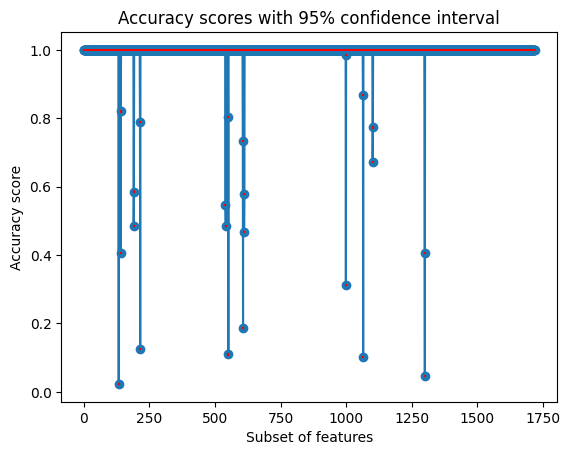

95% confidence interval: [0.99004, 0.99637]


In [ ]:
from scipy import stats
 #plot

# mean silhouette score and confidence interval
mean_score = np.mean(score_list)
ci = stats.t.interval(0.95, len(score_list)-1, loc=mean_score, scale=stats.sem(score_list))

# 2D array with the lower and upper bounds of the confidence interval
yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

# Plot the data with error bars
fig, ax = plt.subplots()
ax.plot(score_list, marker='o')
ax.errorbar(x=range(len(score_list)), y=score_list, yerr=yerr, fmt='none', ecolor='r')
ax.set_xlabel('Subset of features')
ax.set_ylabel('Accuracy score')
ax.set_title('Accuracy scores with 95% confidence interval')
plt.show()

print(f"95% confidence interval: [{ci[0]:.5f}, {ci[1]:.5f}]")

<ipython-input-3-cdb839ecd593>:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])


Accuracy:  0.999800290486565
Confusion Matrix: 
[[    0     1     1]
 [    1 51421     2]
 [    1     5  3648]]


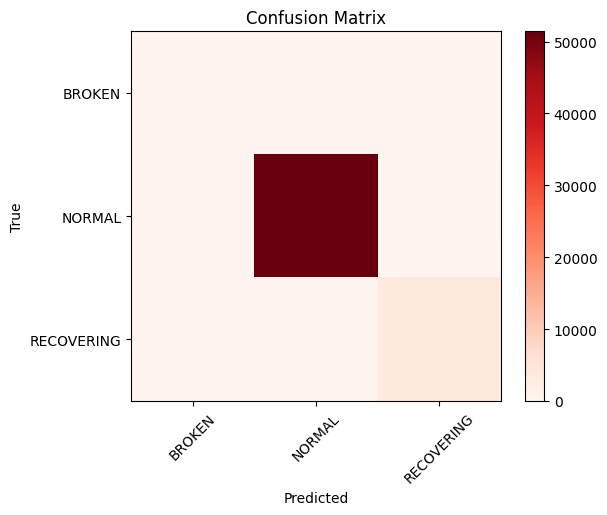

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys

np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# encode BROKEN,NORMAL,RECOVERING -> 0,1,2
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])

# Discard first row + first two columns
df = df.iloc[:, 2:]

data = df.to_numpy(dtype='float')

# Split features X and target y
X = data[:, :-1]
y = data[:, -1]
#print("Class counts: ", np.unique(y, return_counts=True))

# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# data scaling
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# model
KNN_model = KNeighborsClassifier(n_neighbors=1)
KNN_model.fit(X_train_scaled, y_train)

# predictions
y_pred = KNN_model.predict(X_test_scaled)

# Performance (accuracy and confusion matrix)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(conf_mat)

# Plot the confusion matrix
labels = ['BROKEN', 'NORMAL', 'RECOVERING']
plt.imshow(conf_mat, cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.xticks([0,1,2], labels, rotation=45)
plt.yticks([0,1,2], labels)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


# dictionary for testing various values for k and L1, L2 (p = 1, p=2) distance functions
param_knn_grid = {"n_neighbors": np.arange(2, 11, 2), "p" : [1,2]}
#create new knn model instance
knn = KNeighborsClassifier()
#use gridsearch to test all values for k and L1, L2 (p = 1, p=2) distance functions
knn_gridsearch = GridSearchCV(knn, param_knn_grid)
#fit model to training data
knn_gridsearch.fit(X_train_scaled, y_train)
#use the best model
knn_best = knn_gridsearch.best_estimator_
#check best n_neigbors value
print(knn_gridsearch.best_params_)

{'n_neighbors': 2, 'p': 2}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 21)}

# Create a KNN classifier object
KNN_model = KNeighborsClassifier()

# Perform grid search with cross-validation
grid = GridSearchCV(KNN_model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

# Print the best parameter and best score
print("Best parameter: ", grid.best_params_)
print("Best score: ", grid.best_score_)


Best parameter:  {'n_neighbors': 1}
Best score:  0.999885015734689
